# Setup

In [1]:
DATA_VERSION = "2025-05-19"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    ("RESPONSE_FORM",): "SURVEY",
    ("DECISION", "PRESS_RELEASE"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.2
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("merge_classes", MERGE_CLASSES)

mlflow.sklearn.autolog()

Starting run: vaunted-mink-464


2025/05/19 15:44:46 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-05-19.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-05-19.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-05-19.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_id,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53333,55236,5131,2025-05-13,NaT,Revision Personalverordnung (PeV) / [Zeitgemäs...,,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/t3gwchc4,[],[],...,142,Standeskommission Appenzell Innerrhoden,ai,<NA>,openparldata,openparldata,Kanton Appenzell Innerrhoden 172.311-2025\nVe...,None,None,None
53334,55237,5131,2025-05-13,NaT,Revision Personalverordnung (PeV) / [Zeitgemäs...,,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/t3gwchc4,[],[],...,142,Standeskommission Appenzell Innerrhoden,ai,<NA>,openparldata,openparldata,\n \n \nRevision Standeskommis- \nsionsb...,None,None,None
53335,55238,5131,2025-05-13,NaT,Revision Personalverordnung (PeV) / [Zeitgemäs...,,https://www.ai.ch/politik/standeskommission/ka...,https://www.demokratis.ch/vernehmlassung/t3gwchc4,[],[],...,142

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55217,8da3080ba3d712fba760c2ee278e8fdbf9d68e60,False,5,0.0,0.0,0.0,0.0,0.707104
55218,891236708d39f0639e68e40718c971cdade15f41,True,19,19.0,19.0,0.0,0.0,1.414218
55219,0186eda506c9d25020bab51e59b67eaa4e112662,True,427,NaN,NaN,NaN,NaN,NaN


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55236,"[-0.03228657320141792, 0.004587205592542887, -..."
55237,"[-0.006529428064823151, -0.024640865623950958,..."
55238,"[0.004016424063593149, -0.03861880674958229, -..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
    class_merges=MERGE_CLASSES,
)

INFO root: Dropping 1269 documents (5.4%) with empty texts
INFO root: 5359 rows were lost due to missing features. Remaining rows: 16911. 11 columns were added.
INFO root: 0 rows were lost due to missing embeddings. Remaining rows: 16911. 1 columns were added.


## Split

In [13]:
df_input_train, df_input_test = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.29% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.78% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.17% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.22% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.14% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_mod

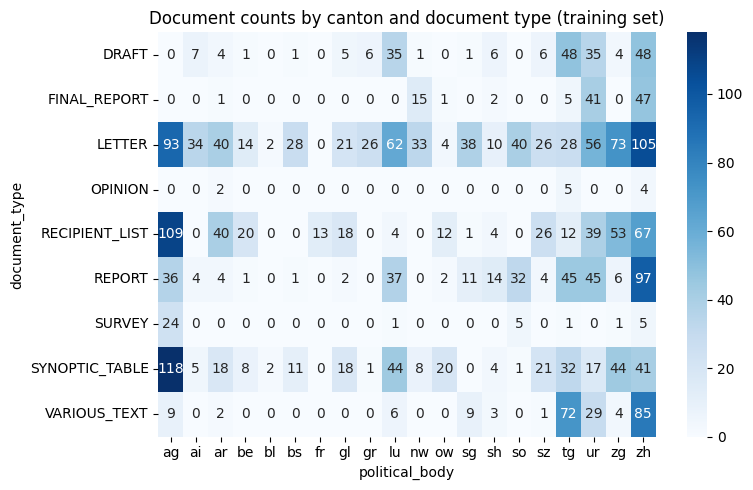

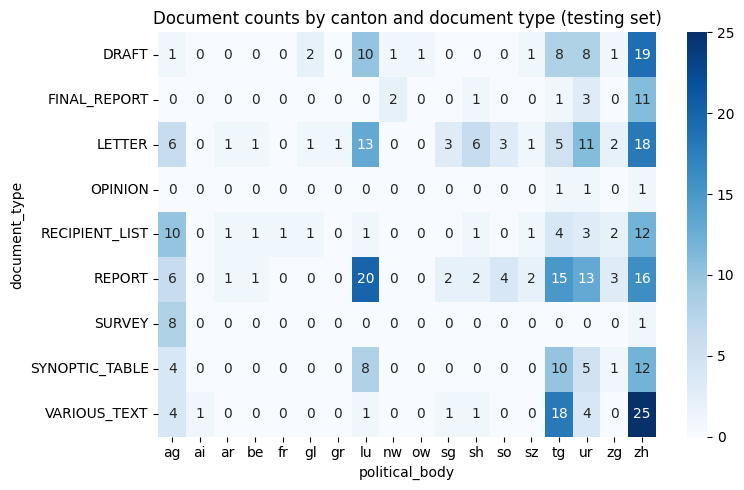

In [14]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test, "testing")

In [15]:
display(df_input_train["document_type_label_source"].value_counts())
display(df_input_train["document_type"].value_counts())

document_type_label_source
fedlex    11605
manual     1484
rule       1009
Name: count, dtype: int64

document_type
LETTER            3087
DRAFT             2892
REPORT            2341
RECIPIENT_LIST    2062
FINAL_REPORT      1727
OPINION            788
VARIOUS_TEXT       618
SYNOPTIC_TABLE     523
SURVEY              60
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [16]:
display(df_input_test["document_type_label_source"].value_counts())
display(df_input_test["document_type"].value_counts())

document_type_label_source
manual    372
Name: count, dtype: int64

document_type
REPORT            85
LETTER            72
VARIOUS_TEXT      55
DRAFT             52
SYNOPTIC_TABLE    40
RECIPIENT_LIST    38
FINAL_REPORT      18
SURVEY             9
OPINION            3
DECISION           0
LINK               0
PRESS_RELEASE      0
RESPONSE_FORM      0
Name: count, dtype: int64

In [17]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

372

# Data exploration

## Data representation

In [18]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source")["document_type"].value_counts()

df_input_train labels:


document_type_label_source  document_type 
fedlex                      DRAFT             2684
                            LETTER            2354
                            REPORT            2000
                            RECIPIENT_LIST    1644
                            FINAL_REPORT      1615
                            OPINION            777
                            VARIOUS_TEXT       398
                            SYNOPTIC_TABLE     110
                            SURVEY              23
                            DECISION             0
                            LINK                 0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
manual                      REPORT             341
                            LETTER             288
                            VARIOUS_TEXT       220
                            DRAFT              208
                            SYNOPTIC_TABLE     157
                            RECIPIENT_L

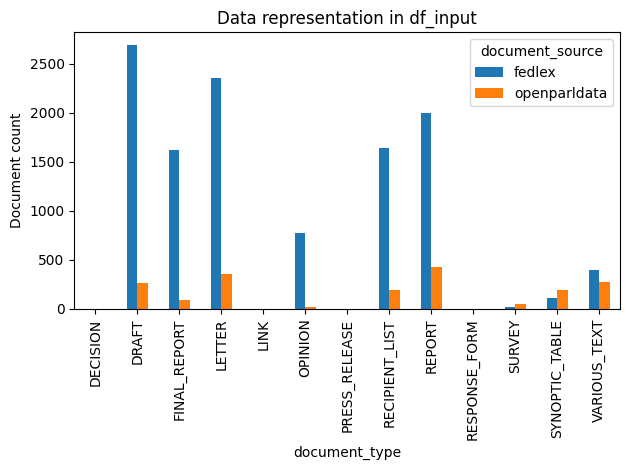

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2684,260
FINAL_REPORT,1615,89
LETTER,2354,360
LINK,0,0
OPINION,777,14
PRESS_RELEASE,0,0
RECIPIENT_LIST,1644,189
REPORT,2000,426


In [19]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [20]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001118,0.000000
FINAL_REPORT,0.003715,0.044944
LETTER,0.985132,0.994444
OPINION,0.745174,0.714286
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.013000,0.035211
SURVEY,0.000000,0.043478
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.015075,0.010909


### Keyword-like features

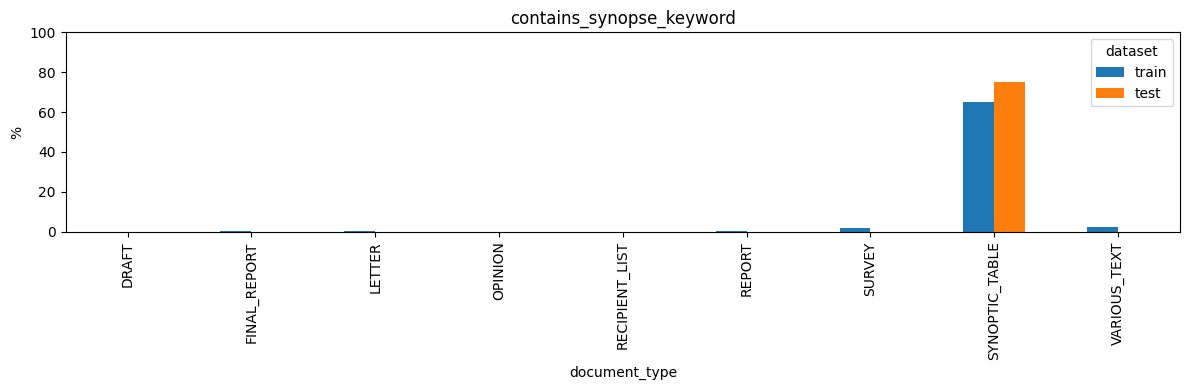

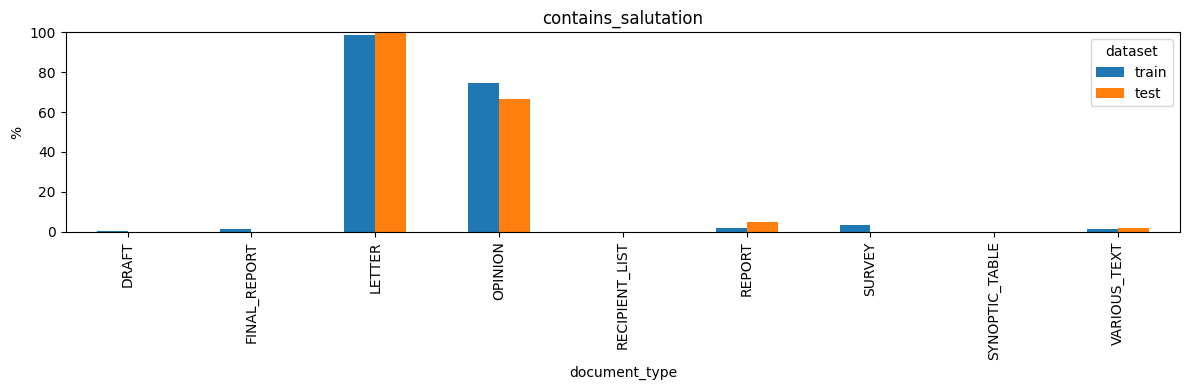

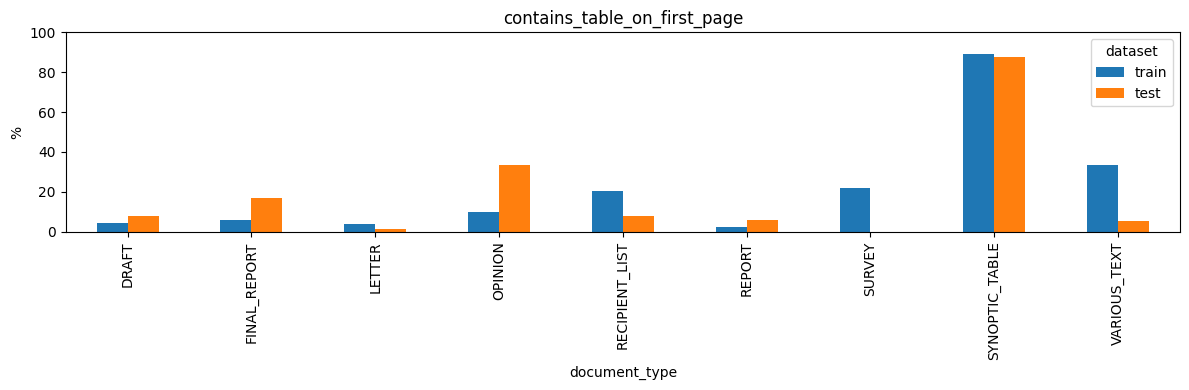

In [21]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_table_on_first_page")

In [22]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

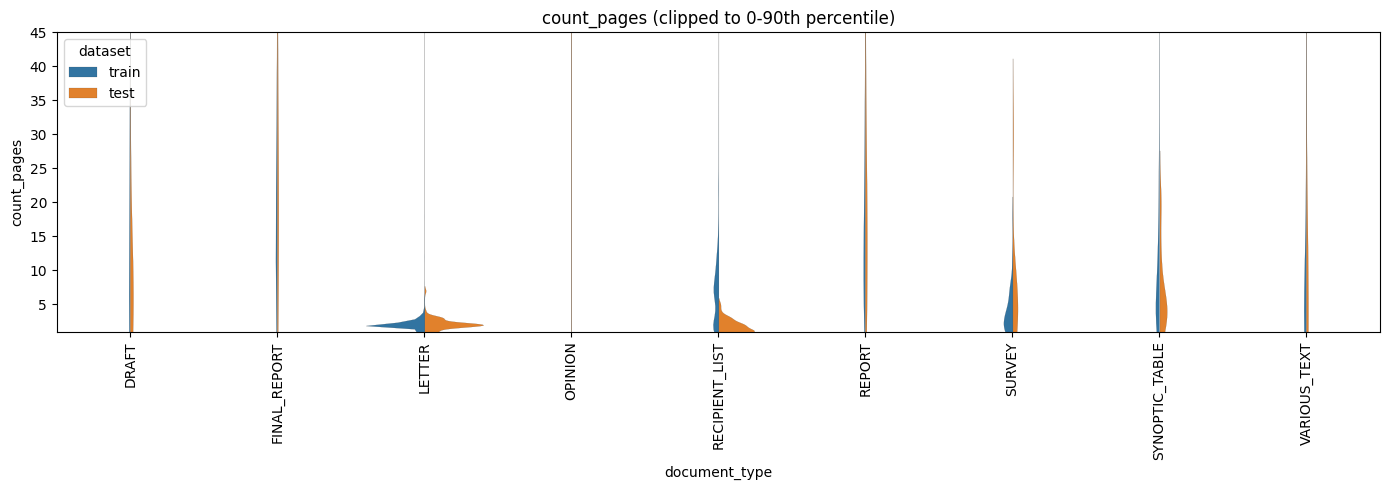

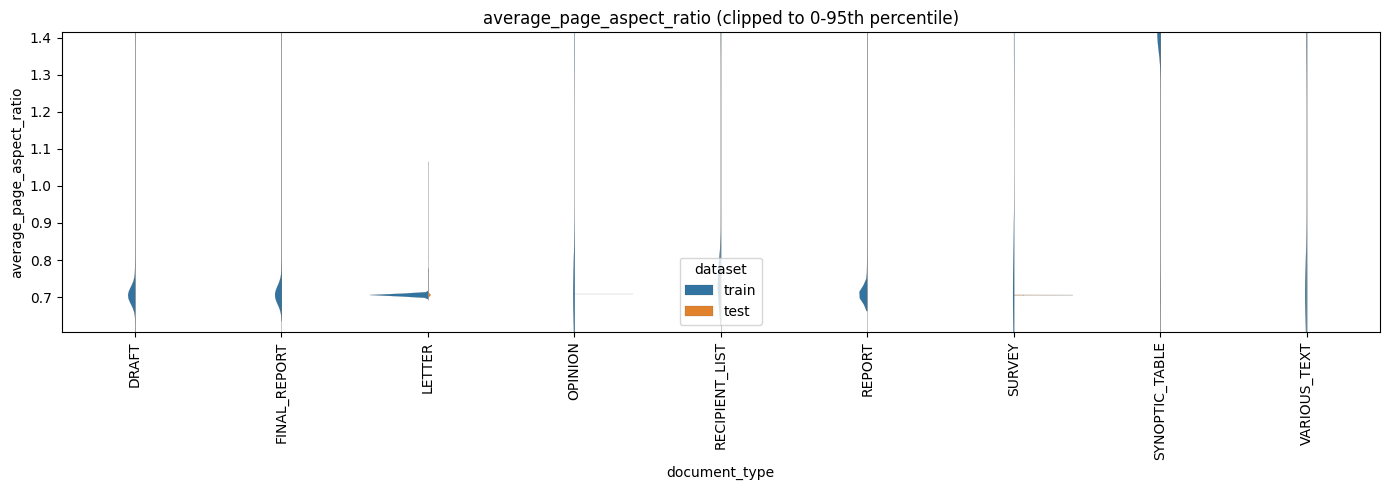

In [23]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [24]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset              test       train       test       train
document_type                                               
DRAFT           10.884615   15.097856  17.829975   85.575964
FINAL_REPORT    32.555556   26.873191  26.760863   44.053383
LETTER           2.152778    2.164561   0.850182    1.415634
OPINION         77.000000  364.261421  76.544105  736.397707
RECIPIENT_LIST   1.815789    7.059651   0.982420    5.413233
REPORT          22.752941   24.774028  29.736904   30.134807
SURVEY           7.222222    3.950000   8.671473    3.249120
SYNOPTIC_TABLE   6.975000   10.841300   5.894315   13.476802
VARIOUS_TEXT    14.727273   14.229773  29.633849   26.880351

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.738415  0.729128  0.141810  0.112186
FINAL_REPORT    0.951756  0.728255  0.294932  0.107360
LETTER          0.708069  0.707823  0.007756  0.014652
OPINION         0.707169  0.826328  0.000000  0.251027
RECIPIENT_LIST  0.744306  0.769989  0.160053  0.181599
REPORT          0.764242  0.724814  0.151355  0.090342
SURVEY          0.707012  0.835537  0.000153  0.269206
SYNOPTIC_TABLE  1.359485  1.368788  0.168372  0.167798
VARIOUS_TEXT    0.737746  0.879412  0.142863  0.301694

### Tables

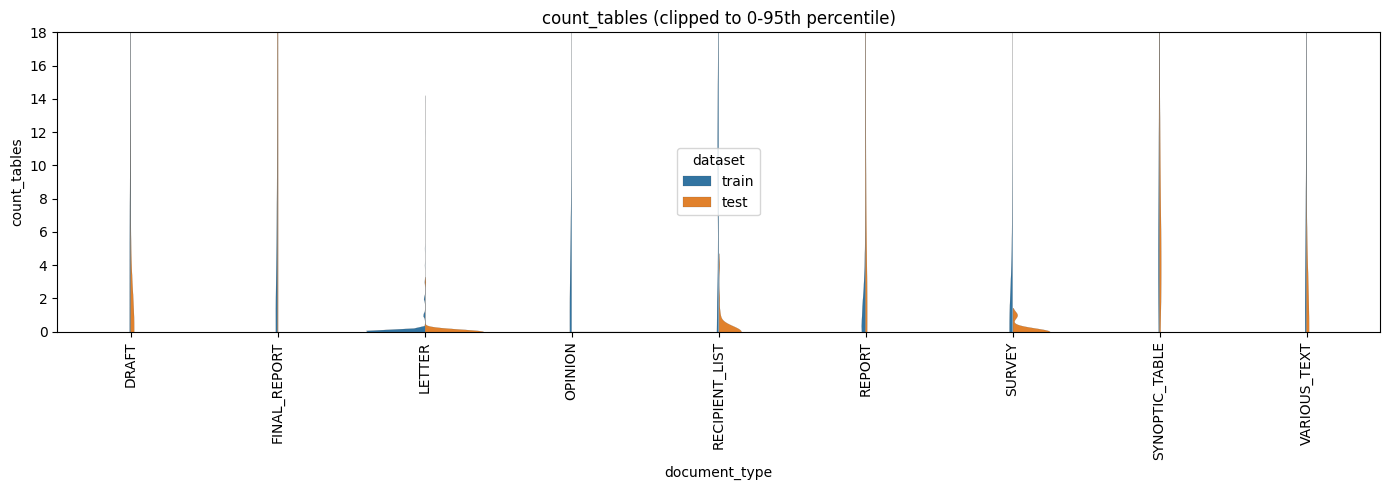

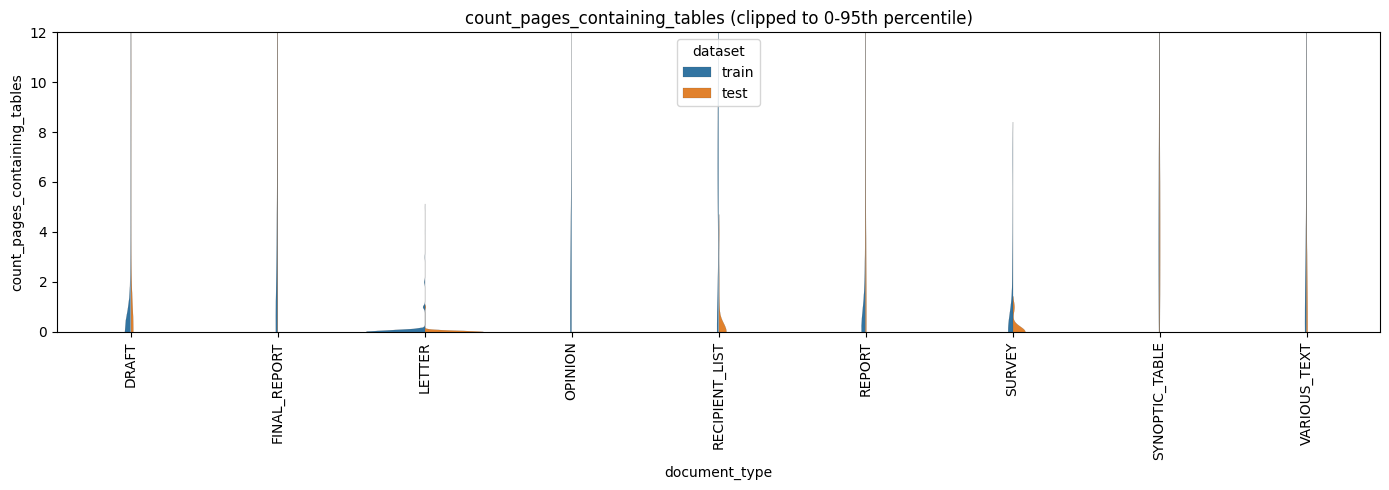

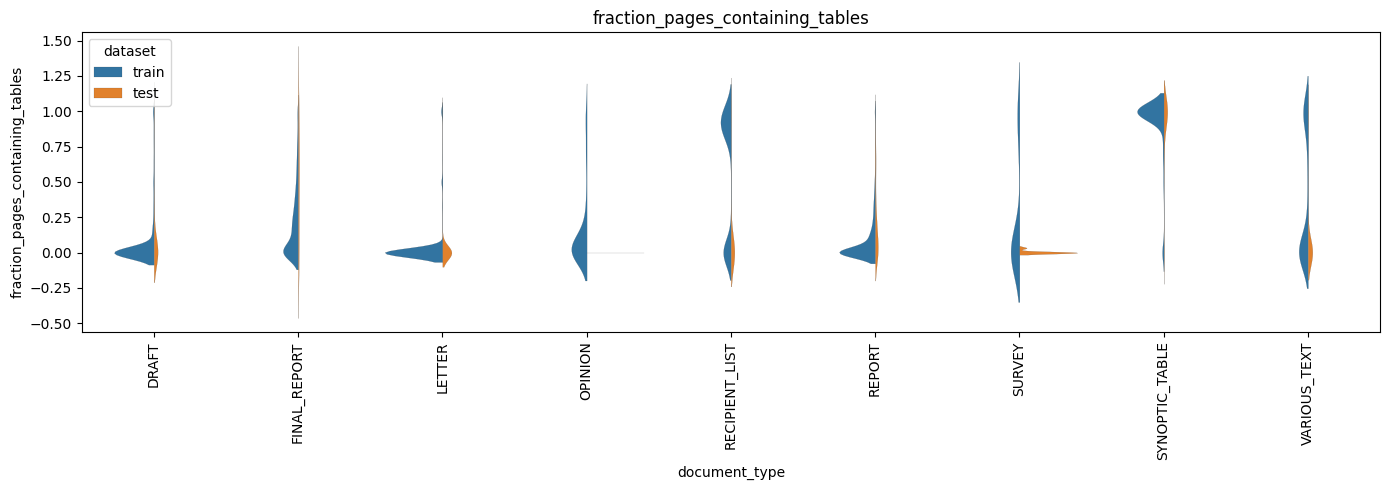

In [26]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_tables")

### Images

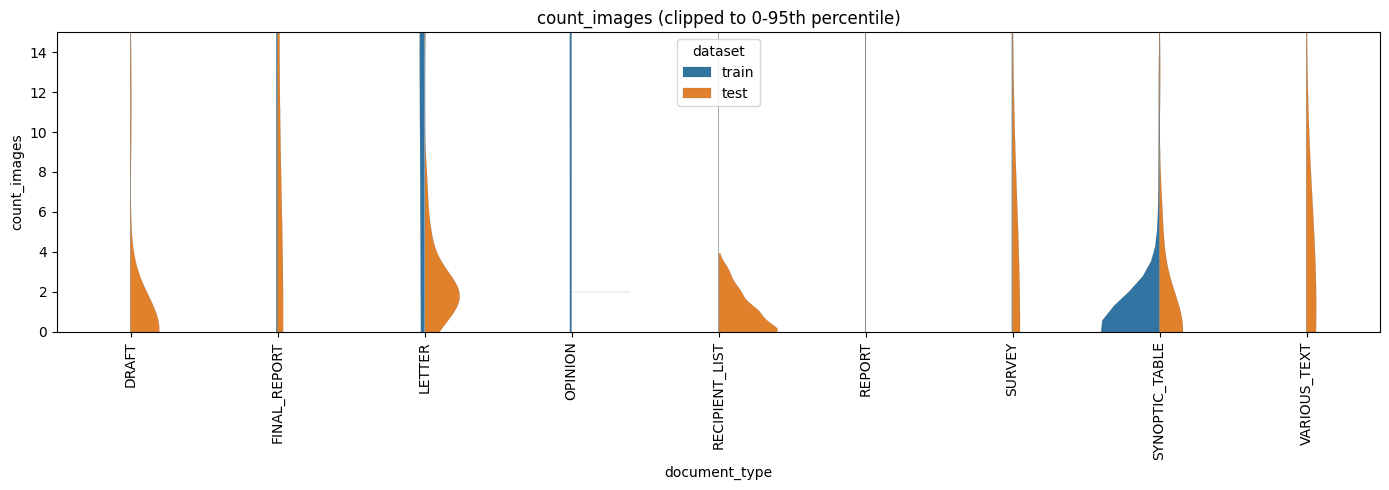

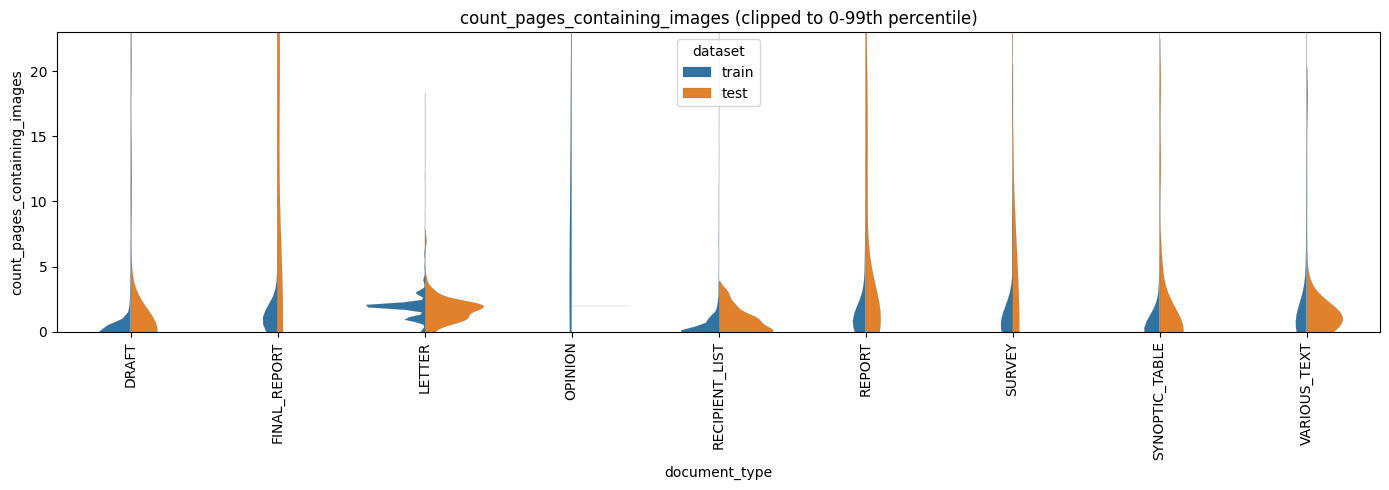

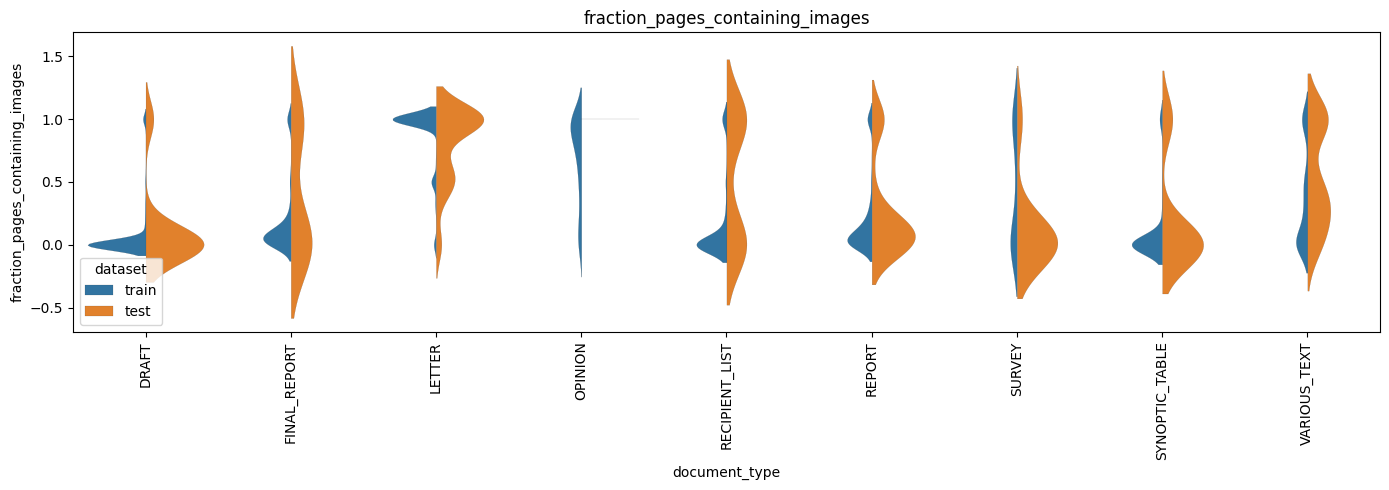

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_images")

# Classification

In [28]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train)
X_test, y_test = demokratis_ml.models.document_types.model.create_matrices(df_input_test)

print("train", X_train.shape)
print("test", X_test.shape)

train (14098, 3079)
test (372, 3079)


In [29]:
classifier = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    random_state=RANDOM_STATE,
)
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3079, None))])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [30]:
def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=CV_FOLDS,
        shuffle=True,
        random_state=RANDOM_STATE,
    ),
    scoring=scoring,
)
scores_docs

{'fit_time': array([7.30256891, 8.10910726, 8.51675415, 7.02224493, 8.50747204]),
 'score_time': array([0.43801403, 0.37907004, 0.41287303, 0.40486813, 0.3728199 ]),
 'test_precision': array([0.92561167, 0.92252834, 0.91454913, 0.91379805, 0.92324884]),
 'test_recall': array([0.9287234 , 0.92553191, 0.91879433, 0.91699184, 0.92692444]),
 'test_f1': array([0.92604105, 0.92331516, 0.91560997, 0.91491809, 0.92451178]),
 'test_pca_explained_variance': array([0.41353863, 0.41278211, 0.41351037, 0.41368523, 0.41389354]),
 'test_accuracy': array([0.9287234 , 0.92553191, 0.91879433, 0.91699184, 0.92692444]),
 'test_top_k_accuracy': array([0.97198582, 0.96950355, 0.9641844 , 0.96594537, 0.96807379])}

## CV evaluation

In [31]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9234,
 'cv_f1': 0.9209,
 'cv_pca_explained_variance': 0.4135,
 'cv_precision': 0.9199,
 'cv_recall': 0.9234,
 'cv_top_k_accuracy': 0.9679}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [32]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [33]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/05/19 15:45:48 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/19 15:46:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.90      0.93      0.91       578
  FINAL_REPORT       0.96      0.97      0.97       345
        LETTER       0.99      1.00      0.99       618
       OPINION       0.94      0.91      0.93       158
RECIPIENT_LIST       1.00      1.00      1.00       412
        REPORT       0.90      0.92      0.91       468
        SURVEY       0.82      0.75      0.78        12
SYNOPTIC_TABLE       0.80      0.81      0.81       105
  VARIOUS_TEXT       0.58      0.42      0.49       124

      accuracy                           0.93      2820
     macro avg       0.88      0.86      0.86      2820
  weighted avg       0.92      0.93      0.93      2820



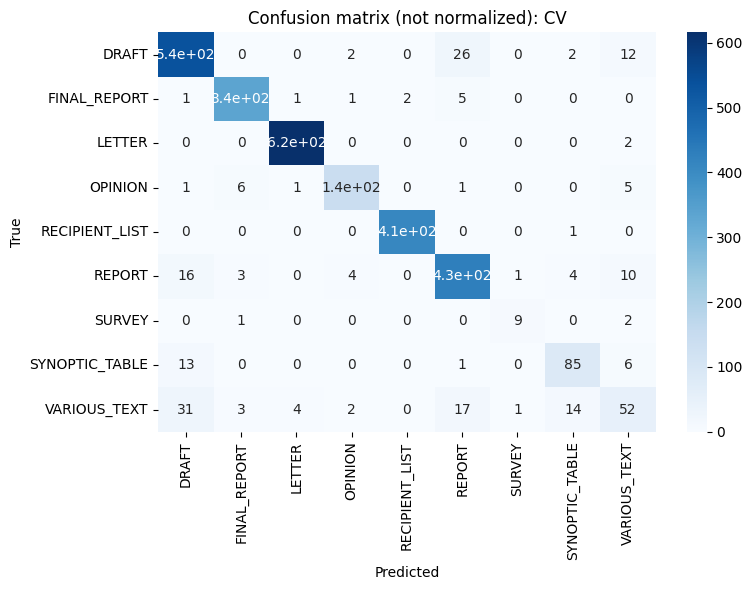

In [34]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

### Feature importance (not implemented)

In [35]:
# explainer = shap.Explainer(classifier)  # .named_steps["logisticregression"])
# shap_values = explainer(X_cv_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])


# def get_shap_values_for_complex_pipeline(pipeline, X_test):
#     # Extract preprocessing steps
#     column_transformer = pipeline.named_steps["columntransformer"]
#     classifier = pipeline.named_steps["logisticregression"]

#     # Transform a small batch of data for initialization
#     background_indices = np.random.choice(X_test.shape[0], 100, replace=False)
#     background_data = column_transformer.transform(X_test[background_indices])

#     # Create explainer with both model and background data
#     explainer = shap.KernelExplainer(classifier.predict, background_data)

#     # Transform the full test data
#     transformed_data = column_transformer.transform(X_test)

#     # Get SHAP values
#     shap_values = explainer.shap_values(transformed_data)

#     return shap_values


# Usage
# shap_values = get_shap_values_for_complex_pipeline(classifier, X_cv_test)
# shap_values


In [36]:
# importances = pd.Series(
#     classifier.named_steps["gradientboostingclassifier"].feature_importances_,
#     index=[f"embedding_{i:02d}" for i in range(20)] + extra_feature_columns,
# )
# importances.sort_values(ascending=False)

## Evaluation on the test set

2025/05/19 15:46:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/19 15:46:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.74      0.77      0.75        52
  FINAL_REPORT       0.73      0.61      0.67        18
        LETTER       0.96      1.00      0.98        72
       OPINION       0.33      0.33      0.33         3
RECIPIENT_LIST       1.00      1.00      1.00        38
        REPORT       0.80      0.82      0.81        85
        SURVEY       1.00      0.67      0.80         9
SYNOPTIC_TABLE       0.88      0.95      0.92        40
  VARIOUS_TEXT       0.72      0.65      0.69        55

      accuracy                           0.84       372
     macro avg       0.80      0.76      0.77       372
  weighted avg       0.84      0.84      0.84       372



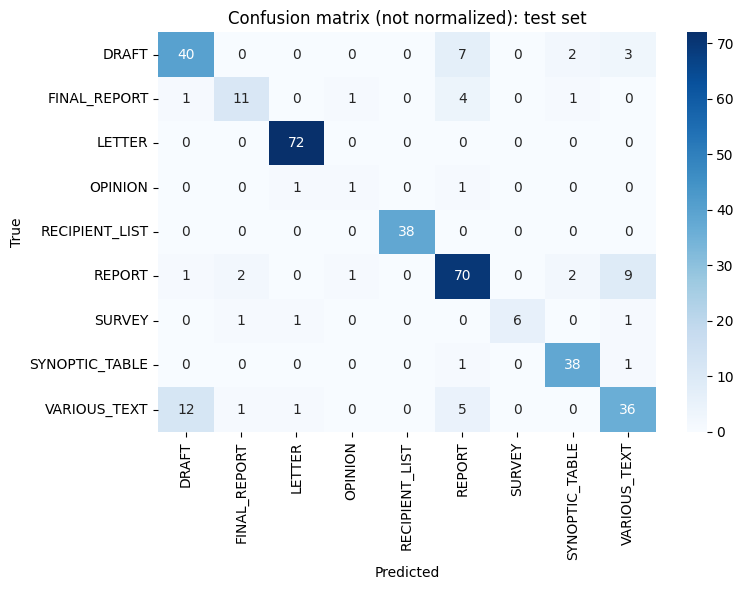

{'test_accuracy': 0.8387,
 'test_f1': 0.8363,
 'test_precision': 0.8371,
 'test_recall': 0.8387,
 'test_top_k_accuracy': 0.9301}


In [37]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
    )
    classifier_test.fit(X_train, y_train)
    y_test_predicted = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        y_test,
        y_test_predicted,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(y_test, y_test_predicted, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        y_test,
        y_test_predicted,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(y_test, y_test_predicted),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test, classifier_test.predict_proba(X_test)),
    )

### Results per canton

In [38]:
df_eval = df_input_test.copy()
df_eval["document_type_predicted"] = y_test_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       0.33      1.00      0.50         1
  FINAL_REPORT       0.00       nan      0.00         0
        LETTER       1.00      1.00      1.00         6
RECIPIENT_LIST       1.00      1.00      1.00        10
        REPORT       0.80      0.67      0.73         6
        SURVEY       1.00      0.75      0.86         8
SYNOPTIC_TABLE       1.00      1.00      1.00         4
  VARIOUS_TEXT       0.67      0.50      0.57         4

      accuracy                           0.85        39
     macro avg       0.73      0.85      0.71        39
  weighted avg       0.92      0.85      0.87        39


------------------------------------------------------------
ai
------------------------------------------------------------
              precision    recall  f1-score   support

      REPORT      

## Comparison: rule-based model

In [39]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df), MERGE_CLASSES
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.96% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.54% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.15% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.54% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_mod

                precision    recall  f1-score   support

         DRAFT       0.70      1.00      0.83        38
  FINAL_REPORT       1.00      0.80      0.89         5
        LETTER       0.98      1.00      0.99        64
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      1.00      1.00        33
        REPORT       0.97      0.90      0.93        79
        SURVEY       1.00      1.00      1.00         8
SYNOPTIC_TABLE       1.00      0.82      0.90        33
  VARIOUS_TEXT       1.00      0.88      0.94        26

      accuracy                           0.93       287
     macro avg       0.96      0.82      0.83       287
  weighted avg       0.95      0.93      0.93       287



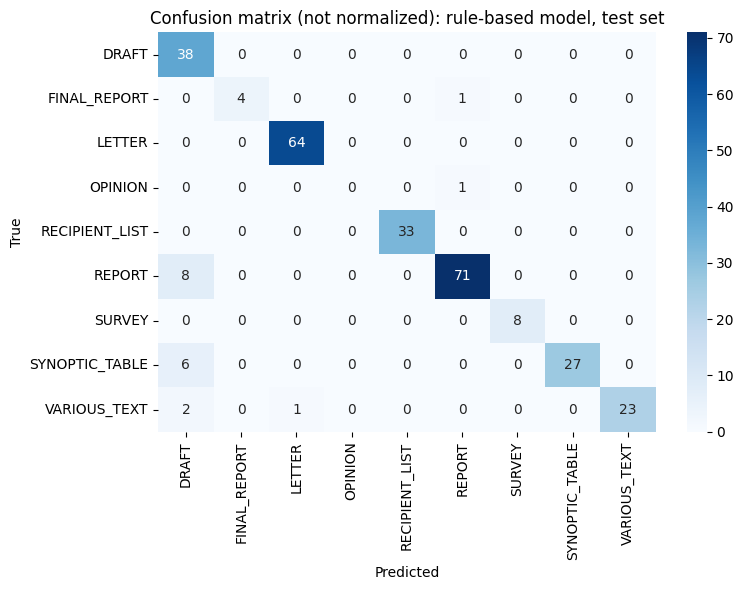

In [40]:
_y_true = y_test[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title="rule-based model, test set",
    # normalize="true",
)

## Display all test samples & predictions

In [41]:
df_display = df_input_test.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f'color: {"green" if row[col] == row["document_type"] else "red"}'
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
42691,43375,lu,vnl,doc,Gesetzesbestimmungen zur Vernehmlassung,DRAFT,nan,DRAFT
39478,39644,ag,vnl,doc,Fragebogen (nicht ausfüllbar),SURVEY,SURVEY,SURVEY
46213,47174,zh,vnl,doc,EB Gesetz Vernehmlassung,DRAFT,nan,DRAFT
47064,48035,zh,vnl,doc,Adressatenliste,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
46914,47883,zh,vnl,doc,Entwürfe VSV & VSM,FINAL_REPORT,nan,REPORT
47598,48592,zh,vnl,doc,Adressatenliste,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
48176,49204,zh,vnl,doc,Auszug aus dem Protokoll des RR 271,VARIOUS_TEXT,nan,DRAFT
47620,48616,zh,vnl,doc,Auszug aus dem Protokoll des RR,VARIOUS_TEXT,nan,VARIOUS_TEXT
50140,51272,ur,vnl,doc,Begleitbrief zur Vernehmlassung,LETTER,LETTER,LETTER
38671,38700,ag,vnl,doc,Verzeichnis der Anhörungsadressaten,RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST


***

# End run

In [42]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [43]:
mlflow.end_run()

🏃 View run vaunted-mink-464 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/aac9a1c351ec4a97911e88beac90f953
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
